<a href="https://colab.research.google.com/github/DanielRajChristeen/Custom-trained-YOLOv11-Model/blob/main/Custom_YOLOv11_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ------------------------------
# YOLOv11 Road Sign Detection
# ------------------------------

# Step 0: Install dependencies
!pip install ultralytics opencv-python kaggle --quiet


In [4]:
# Step 1: Upload Kaggle API token
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielrajchristeen","key":"5f786795c45010515bb6617ae389f0ce"}'}

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"danielrajchristeen","key":"5f786795c45010515bb6617ae389f0ce"}'}

In [6]:
# Move token to correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 2: Download and unzip dataset
!kaggle datasets download -d andrewmvd/road-sign-detection
!unzip -q road-sign-detection.zip -d dataset

# Verify files
import os
print("Dataset files:", os.listdir("dataset"))

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 86% 188M/218M [00:00<00:00, 588MB/s] 
100% 218M/218M [00:00<00:00, 488MB/s]
Dataset files: ['annotations', 'images']


In [7]:
import os, shutil, random
from pathlib import Path
import xml.etree.ElementTree as ET

# Folders
img_folder = Path("dataset/images")
ann_folder = Path("dataset/annotations")
base_folder = Path("yolo_dataset")
(base_folder/"images/train").mkdir(parents=True, exist_ok=True)
(base_folder/"images/val").mkdir(parents=True, exist_ok=True)
(base_folder/"labels/train").mkdir(parents=True, exist_ok=True)
(base_folder/"labels/val").mkdir(parents=True, exist_ok=True)

def voc_to_yolo(xml_file, img_w, img_h):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    lines = []
    for obj in root.findall("object"):
        cls = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h
        lines.append(f"0 {x_center} {y_center} {width} {height}")
    return "\n".join(lines)

# Get all PNG images
all_imgs = [f for f in os.listdir(img_folder) if f.endswith(".png")]
random.shuffle(all_imgs)
split = int(0.8 * len(all_imgs))
train_imgs = all_imgs[:split]
val_imgs = all_imgs[split:]

def process(img_list, split_type):
    for img_name in img_list:
        stem = Path(img_name).stem
        xml_path = ann_folder / f"{stem}.xml"
        if not xml_path.exists():
            continue  # skip if no annotation

        # copy image
        shutil.copy(img_folder / img_name, base_folder / "images" / split_type / img_name)

        # get width/height from XML
        tree = ET.parse(xml_path)
        size = tree.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        # convert
        yolo_txt = voc_to_yolo(xml_path, w, h)
        with open(base_folder / "labels" / split_type / f"{stem}.txt", "w") as f:
            f.write(yolo_txt)

process(train_imgs, "train")
process(val_imgs, "val")

print("✅ Conversion complete")

✅ Conversion complete


In [8]:
# Step 4: Create dataset YAML file
yaml_content = """
train: yolo_dataset/images/train
val: yolo_dataset/images/val
nc: 4
names: ['Trafic Light', 'Stop', 'Speedlimit', 'Crosswalk']
"""
with open("road_sign.yaml", "w") as f:
    f.write(yaml_content)
print("Dataset YAML created!")

Dataset YAML created!


In [9]:
# Step 5: Train YOLOv11 model
from ultralytics import YOLO

model = YOLO('yolo11n.pt')  # nano model for quick training
model.train(data='road_sign.yaml', epochs=50, imgsz=416, batch=8)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=road_sign.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79d13fc00170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [10]:
# Step 6: Evaluate the model
metrics = model.val()
print(metrics)

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1485.2±627.3 MB/s, size: 210.8 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 164.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 1.2it/s 18.7s
                   all        176        246      0.967      0.941      0.969      0.844
          Trafic Light        176        246      0.967      0.941      0.969      0.844
Speed: 0.7ms preprocess, 89.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /content/runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metri

In [ ]:
from pathlib import Path
from PIL import Image
import IPython.display as display

run_dir = Path("runs/detect/train32")

# Show all .png and .jpg images in the directory
for img_path in run_dir.glob("*.png"):
    print(f"\nShowing: {img_path.name}")
    display.display(Image.open(img_path))

for img_path in run_dir.glob("*.jpg"):
    print(f"\nShowing: {img_path.name}")
    display.display(Image.open(img_path))


image 1/1 /content/yolo_dataset/images/val/road21.png: 416x320 5 Trafic Lights, 125.9ms
Speed: 2.9ms preprocess, 125.9ms inference, 11.8ms postprocess per image at shape (1, 3, 416, 320)


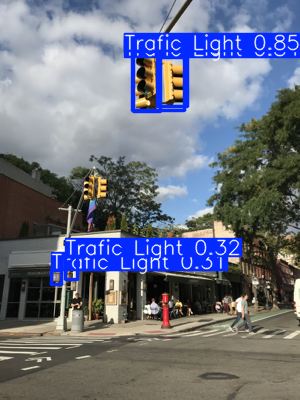

In [12]:
# Step 7: Make predictions on sample images
sample_image = list((base_folder/"images/val").glob("*.png"))[0]
results = model.predict(str(sample_image))
results[0].show()